In [ ]:
import tensorflow_datasets as tfds
# load dataset
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.C3XP6P_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.C3XP6P_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
import tensorflow as tf
# normalize the image
def normalize(image, mask):
  image = tf.cast(image, tf.float32) / 255.
  mask -= 1
  return image, mask

# load images
def load_image(datapoint):
  image = tf.image.resize(datapoint["image"], (128, 128))
  mask = tf.image.resize(
      datapoint["segmentation_mask"],
      (128,128),
      method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
  )

  image, mask = normalize(image, mask)
  return image, mask

In [ ]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset["test"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

Perform augmentation by randomly flipping an image

In [ ]:
class Augment(tf.keras.layers.Layer):

  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Input pipeline


In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and the mask from the dataset

In [ ]:
import matplotlib.pyplot as plt
def display(display_list):
  plt.figure(figsize=(15,15))

  title=["Input Image", "True Mask", "Predicated Mask", "Masked image"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")

  plt.show()

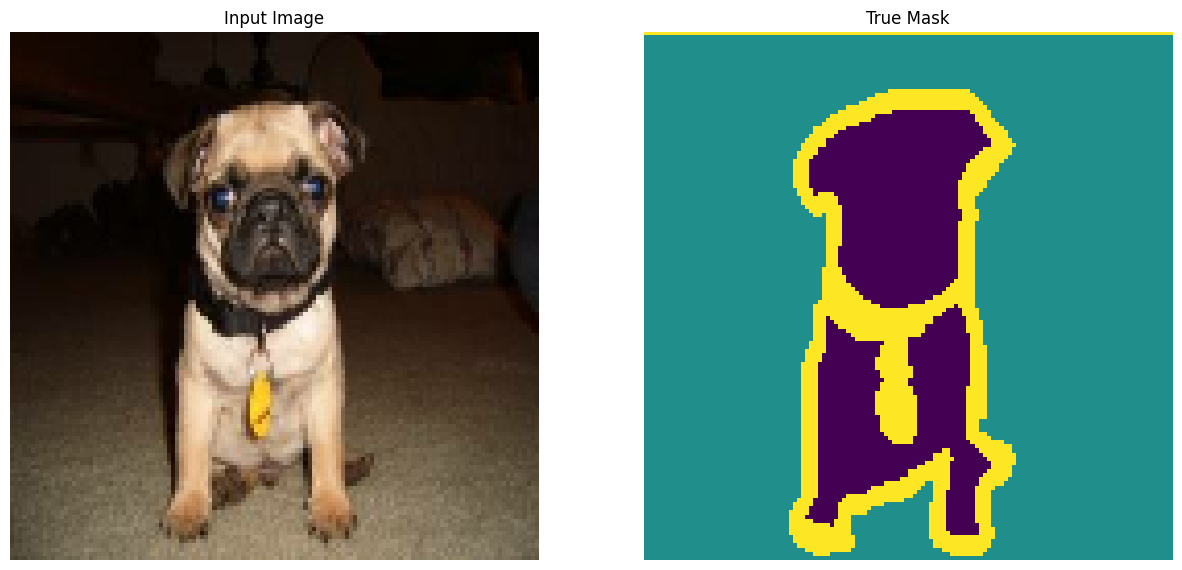

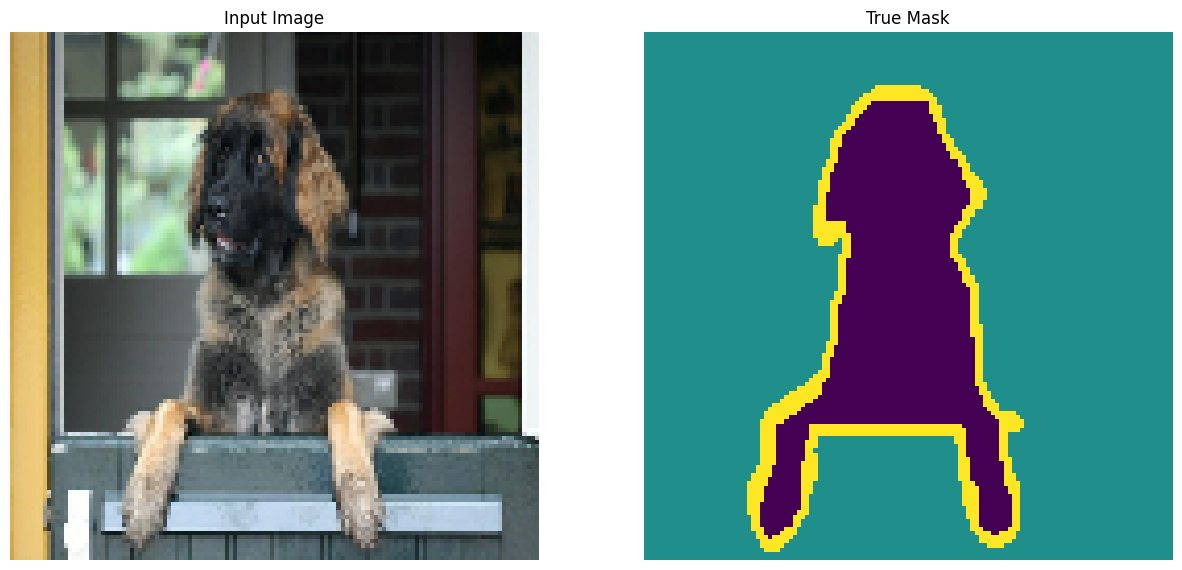

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

##Define the model

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3], include_top=False)

# use activations of these layers
layer_names = [
    "block_1_expand_relu", #64x64
    "block_3_expand_relu", #32x32
    "block_6_expand_relu", #16x16
    "block_13_expand_relu", #8x8
    "block_16_project" #4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# create feature extractor
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-t_k06vc0
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-t_k06vc0
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=7cbcc30b18ebf30acee9910d77154a96ac6632d05af3296b556c97cc11a708ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-ap_jmy26/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3), #4x4 -> 8x8
    pix2pix.upsample(256, 3), #8x8 -> 16x16
    pix2pix.upsample(128, 3), #16x16 -> 32x32
    pix2pix.upsample(64, 3), #32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

plot and see the model

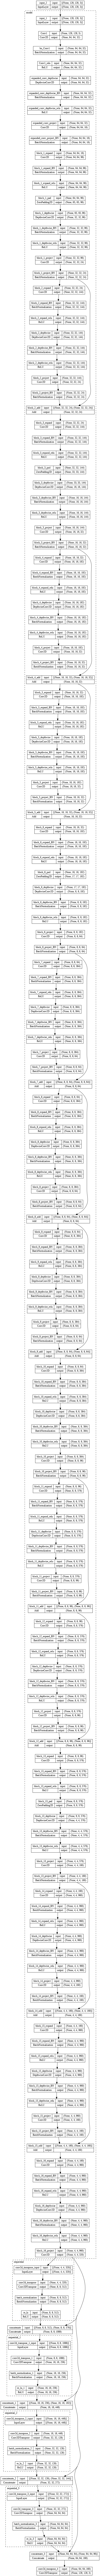

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

In [ ]:
# create mask
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
# merge mask and image
def merge_mask(mask, img):
  # get pil objects from original and mask
  masked = tf.keras.utils.array_to_img(mask)
  image = tf.keras.utils.array_to_img(img)
  mask_pxl = masked.load()
  img_pxl = image.load()
  print(img_pxl[0,0])
  # interested in 0 values
  for i in range(128):
    for j in range(128):
      if mask_pxl[i,j] != 0:
        img_pxl[i,j] = (0,0,0)

  return image

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      converted_mask = create_mask(pred_mask)
      merged = merge_mask(converted_mask, image[0])
      display([image[0], mask[0], converted_mask, merged])

  else:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 8s 8s/step


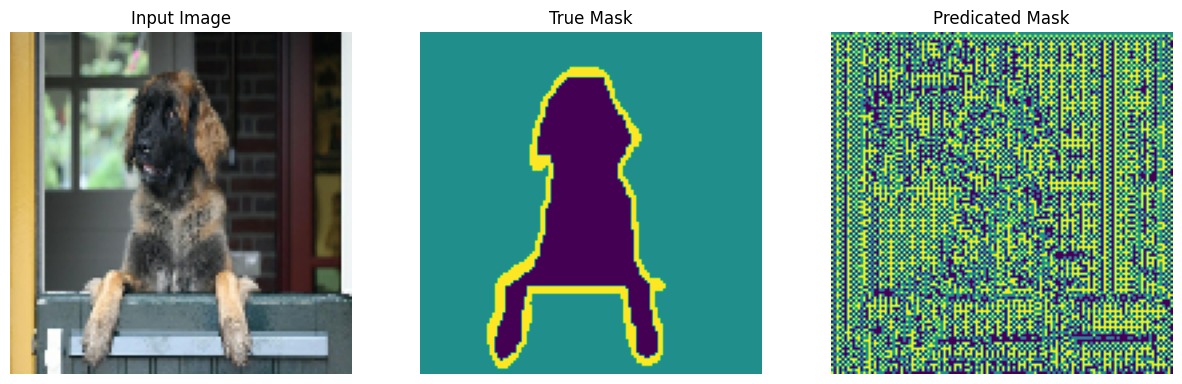

In [ ]:
show_predictions()

Callback function to observe how the model improves while it's training

In [ ]:
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print(f"\n sample prediction after epoch {epoch+1}")

1/1 [==============================] - 0s 21ms/step


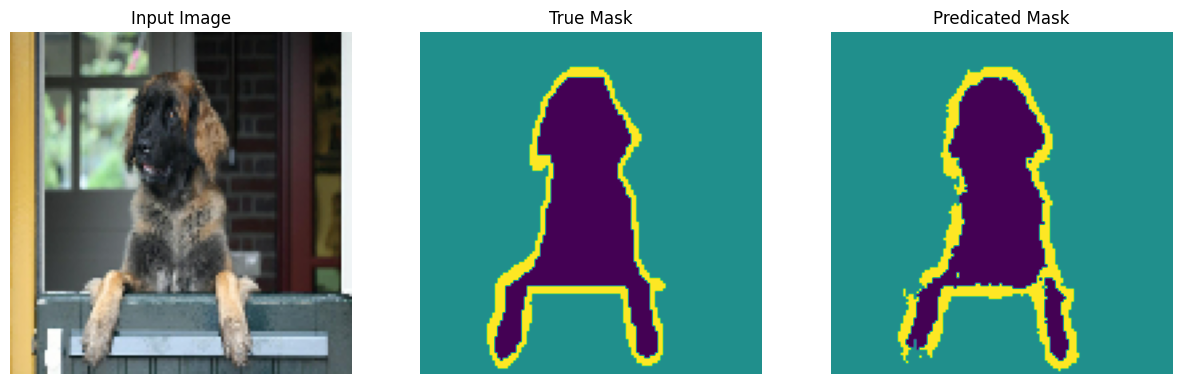


 sample prediction after epoch 20
57/57 [==============================] - 9s 155ms/step - loss: 0.1716 - accuracy: 0.9301 - val_loss: 0.2769 - val_accuracy: 0.9002


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["test"].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS, validation_data=test_batches,
                          callbacks=[DisplayCallback()])

Plot validation loss

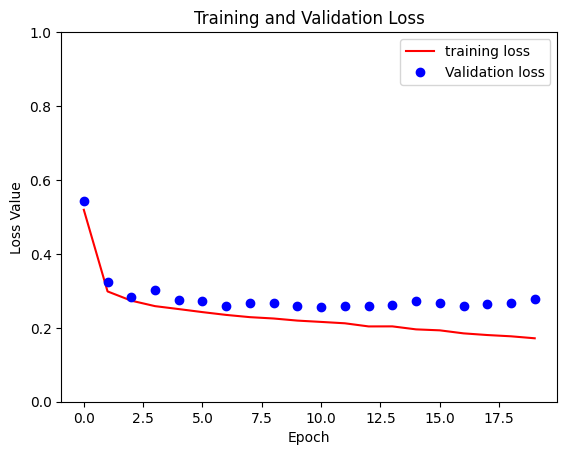

In [ ]:
loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]

plt.figure()
plt.plot(model_history.epoch, loss, "r", label="training loss")
plt.plot(model_history.epoch, val_loss, "bo", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Make Predictions

2/2 [==============================] - 0s 25ms/step
(249, 240, 231)


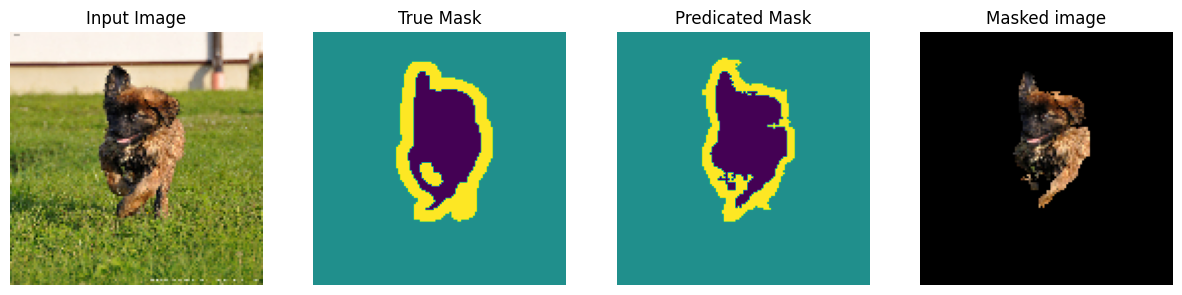

In [ ]:
show_predictions(test_batches, 1)

Save the model

In [ ]:
model.save("unet_dejando_huella_v2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.10/dist-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.
  warnings.warn(


In [ ]:
# download saved model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
